In [99]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=os.path.join('studio', '.env'))
print("TAVILY_API_KEY loaded:", os.getenv("TAVILY_API_KEY") is not None)

TAVILY_API_KEY loaded: True


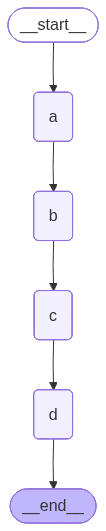

In [100]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [101]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

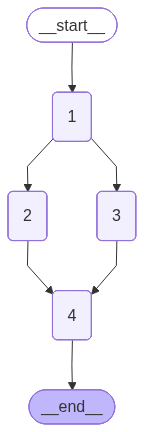

In [102]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("1", ReturnNodeValue("Node 1"))
builder.add_node("2", ReturnNodeValue("Node 2"))
builder.add_node("3", ReturnNodeValue("Node 3"))
builder.add_node("4", ReturnNodeValue("Node 4"))

# Flow
builder.add_edge(START, "1")
builder.add_edge("1", "2")
builder.add_edge("1", "3")
builder.add_edge("2", "4")
builder.add_edge("3", "4")
builder.add_edge("4", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [103]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding Node 1 to []
Adding Node 2 to ['Node 1']
Adding Node 3 to ['Node 1']
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


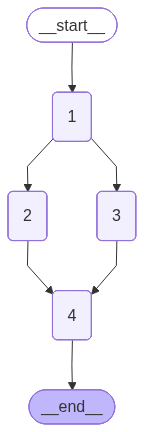

In [104]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("1", ReturnNodeValue("Node 1"))
builder.add_node("2", ReturnNodeValue("Node 2"))
builder.add_node("3", ReturnNodeValue("Node 3"))
builder.add_node("4", ReturnNodeValue("Node 4"))

# Flow
builder.add_edge(START, "1")
builder.add_edge("1", "2")
builder.add_edge("1", "3")
builder.add_edge("2", "4")
builder.add_edge("3", "4")
builder.add_edge("4", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [105]:
graph.invoke({"state": []})

Adding Node 1 to []
Adding Node 2 to ['Node 1']
Adding Node 3 to ['Node 1']
Adding Node 4 to ['Node 1', 'Node 2', 'Node 3']


{'state': ['Node 1', 'Node 2', 'Node 3', 'Node 4']}

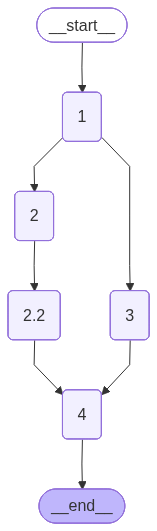

In [106]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("1", ReturnNodeValue("Node 1"))
builder.add_node("2", ReturnNodeValue("Node 2"))
builder.add_node("2.2", ReturnNodeValue("Node 2.2"))
builder.add_node("3", ReturnNodeValue("Node 3"))
builder.add_node("4", ReturnNodeValue("Node 4"))

# Flow
builder.add_edge(START, "1")
builder.add_edge("1", "2")
builder.add_edge("1", "3")
builder.add_edge("2", "2.2")
builder.add_edge(["2.2", "3"], "4")
builder.add_edge("4", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [107]:
graph.invoke({"state": []})

Adding Node 1 to []
Adding Node 2 to ['Node 1']
Adding Node 3 to ['Node 1']
Adding Node 2.2 to ['Node 1', 'Node 2', 'Node 3']
Adding Node 4 to ['Node 1', 'Node 2', 'Node 3', 'Node 2.2']


{'state': ['Node 1', 'Node 2', 'Node 3', 'Node 2.2', 'Node 4']}

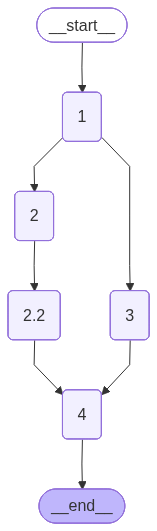

In [108]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("1", ReturnNodeValue("Node 1"))
builder.add_node("2", ReturnNodeValue("Node B"))
builder.add_node("2.2", ReturnNodeValue("Node 2.2"))
builder.add_node("3", ReturnNodeValue("Node 3"))
builder.add_node("4", ReturnNodeValue("Node 4"))

# Flow
builder.add_edge(START, "1")
builder.add_edge("1", "2")
builder.add_edge("1", "3")
builder.add_edge("2", "2.2")
builder.add_edge(["2.2", "3"], "4")
builder.add_edge("4", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [109]:
graph.invoke({"state": []})

Adding Node 1 to []
Adding Node B to ['Node 1']
Adding Node 3 to ['Node 1']
Adding Node 2.2 to ['Node 1', 'Node 3', 'Node B']
Adding Node 4 to ['Node 1', 'Node 2.2', 'Node 3', 'Node B']


{'state': ['Node 1', 'Node 2.2', 'Node 3', 'Node 4', 'Node B']}

In [110]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=1) 

In [111]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

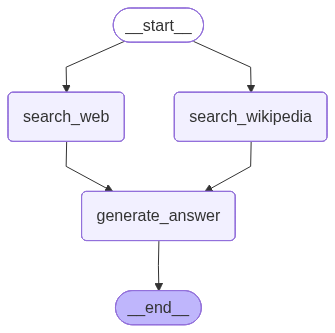

In [112]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [113]:
result = graph.invoke({"question": "What is Dravidian Theory?"})
result['answer'].content

'The Dravidian Theory refers to the historical and cultural understanding of the Dravidian people and their languages in South Asia. It posits that the Dravidian languages, which are primarily spoken in southern India and parts of Sri Lanka, are part of an ethnolinguistic family separate from the Indo-European languages brought by the Indo-Aryan migration. The theory suggests that the Dravidian languages predate the arrival of Indo-Aryan languages in India. The Dravidian migration theory speculates that the Dravidian languages may have been introduced to India by early migrations from Western Asia, indicating a possible ancient link to regions like the Iranian plateau. It also proposes that the language of the Indus Valley Civilization might have been of Dravidian origin. The theory highlights the rich cultural and linguistic tradition of the Dravidian people and their significant presence in the Indian subcontinent prior to the arrival of Indo-Aryan languages.'

In [114]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [115]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [116]:
thread = await client.threads.create()
input_question = {"question": "What is Dravidian Theory?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])